# Tutorial: Approaches to prompt engineering

In Chapter 4 we discussed various methods of template engineering with the goal of improving the analytic capabilities of prompt-tuned LLMs. As part of this discussion, we demonstrated online web applications that could be harnessed to do prompt-based inference and information retrieval, demonstrating the sensitivity of results to choices in template architecture and the fine details of prompt composition.

While these web applications are valuable for exploring certain features of masked language prediction, they are limited in their capability for full prompt-based fine-tuning solutions. As such in this tutorial, we will expand on these exercises by exploring few- and many-shot prompt-tuning, discussing results for variable prompt template designs, with a goal towards grasping the critical importance of prompt template optimization.






In [ ]:
!pip install openprompt
!pip install datasets
!pip install transformers==4.19.0

In [2]:
import time
import os
import string
import copy
import torch
from tqdm import tqdm
import pandas as pd
import numpy as np

from transformers import  AdamW, get_linear_schedule_with_warmup
from transformers.optimization import Adafactor, AdafactorSchedule
from datasets import load_dataset

from openprompt.plms import load_plm
from openprompt import PromptDataLoader
from openprompt.data_utils.utils import InputExample
from openprompt.prompts import ManualTemplate, ManualVerbalizer, MixedTemplate, SoftTemplate
from openprompt.prompts.prefix_tuning_template import PrefixTuningTemplate
from openprompt import PromptForClassification
from openprompt.utils.reproduciblity import set_seed
set_seed(13)

In [3]:
## SOFT PROMPT TUNING

class SoftPromptTuningArgs:
    seed = 144
    plm_eval_mode = True
    tune_plm = False
    max_steps = 20000
    prompt_lr = 0.3
    warmup_step_prompt = 500
    soft_token_num = 20

class FixedPromptTuningArgs:
    seed = 144
    plm_eval_mode = False
    tune_plm = True
    max_steps = 100 #20000
    prompt_lr = 0.3
    warmup_step_prompt = 500
    soft_token_num = 20

In this tutorial we consider the *SuperGLUE BoolQ* data set, which provides triplets of an informational paragraph, a yes or no question related to the content of the paragraph, and the correct response. Here is an example datum from this set:

> **Passage**: "Look What You Made Me Do" is a song recorded by American singer-songwriter Taylor Swift, released on August 24, 2017 by Big Machine Records as
the lead single from her sixth studio album Reputation (2017). Swift wrote the
song with her producer Jack Antonoff. "Look What You Made Me Do" is an
electroclash and pop song, with lyrics about various issues that built Swift's
reputation. Right Said Fred band members Fred Fairbrass, Richard Fairbrass,
and Rob Manzoli are also credited as songwriters, as it interpolates the
melody of their song "I'm Too Sexy" (1991).
>
> **Question**: "did taylor swift write look what you made me do"
>
> **Label**: 1 (yes)

The BoolQ dataset is very expansive in its topics coverage, including history, science, geography, law, sports, pop culture, and more, making it a fascinating dataset for exploring the natural language inference capabilities of LLMs. These three components will be incorporated into a prompt template and the LLM tuned with these samples.

In [4]:
def read_glue_boolq_dataset(tokenizer=None, max_len=512):
    ogdataset = load_dataset('super_glue','boolq')

    ogdataset['train'] = ogdataset['train'].shuffle(seed=1989).select(range(5000))
    ogdataset['test'] = ogdataset['validation'].shuffle(seed=1989).select(range(1800,3270))
    ogdataset['validation'] = ogdataset['validation'].shuffle(seed=1989).select(range(1800))

    # create a dataset of opemprompt InputExamples from the training data
    from openprompt.data_utils import InputExample
    dataset = {}
    for split in ['train', 'validation', 'test']:
        if split in ('test','validation'): ipos, ineg = 0, 0
        dataset[split] = []
        for data in ogdataset[split]:
            ## Throw away samples that are too long.
            if tokenizer != None:
                testlen = data['passage']+' '+data['question']
                if len(tokenizer.tokenize(testlen)) > max_len:
                    continue
            ## Getting 50/50 for validation
            if split in ('test','validation'):
                if data['label'] in (1,'1'):
                     if ipos >= 500: continue
                     ipos += 1
                if data['label'] in (0,'0'):
                     if ineg >= 500: continue
                     ineg += 1
            ## Create input examples
            input_example = InputExample(text_a = data['passage'],
                                        text_b = data['question'],
                                        label=data['label'],
                                      # idx=data['idx'],
                                        guid = "%s-%s" % (split, data['idx']))
            dataset[split].append(input_example)

    return dataset

In [5]:
## Create a two-parameter verbalizer mapped to "yes" and "no"
def set_verbalizer_model(mytemplate, tokenizer, plm, use_cuda):
    myverbalizer = ManualVerbalizer(tokenizer, label_words=[['no','No'],['yes','Yes']], num_classes = 2)
    prompt_model = PromptForClassification(plm=plm, template=mytemplate, verbalizer=myverbalizer,
                                           freeze_plm = False)
    if use_cuda:
        prompt_model = prompt_model.cuda()
    return prompt_model

## OpenPrompt dataloader routine
def create_dataloader(dataset, mytemplate, tokenizer, WrapperClass, max_seq_l, batchsize_t,
                      shuffle, seed):

    the_dataloader = PromptDataLoader(dataset=dataset, template=mytemplate, tokenizer=tokenizer,
        tokenizer_wrapper_class=WrapperClass, max_seq_length=max_seq_l, decoder_max_length=3,
        batch_size=batchsize_t,shuffle=shuffle, teacher_forcing=False,
        predict_eos_token=False, truncate_method="tail",seed=seed)
    return the_dataloader

## Implement standard accuracy metric for assessing prediction quality.
def evaluate(prompt_model, dataloader, use_cuda, desc):
    prompt_model.eval()
    allpreds = []
    alllabels = []

    for step, inputs in enumerate(dataloader):
        if use_cuda:
            inputs = inputs.cuda()
        logits = prompt_model(inputs)
        labels = inputs['label']
        alllabels.extend(labels.cpu().tolist())
        allpreds.extend(torch.argmax(logits, dim=-1).cpu().tolist())
    acc = sum([int(i==j) for i,j in zip(allpreds, alllabels)])/len(allpreds)
    return acc

## Configuring LLM and prompt for fine-tuning.
def set_plm_prompt_optimizers(prompt_model, tune_plm, tune_prompt, tot_step,
                              learn_rate,args):
    loss_func = torch.nn.CrossEntropyLoss()
    optimizer1 = None
    scheduler1 = None
    optimizer2 = None
    scheduler2 = None

    if tune_plm:
        no_decay = ['bias', 'LayerNorm.weight']
        optimizer_grouped_parameters1 = [
            {'params': [p for n, p in prompt_model.plm.named_parameters() if (not any(nd in n for nd in no_decay))], 'weight_decay': 0.01},
            {'params': [p for n, p in prompt_model.plm.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]
        optimizer1 = AdamW(optimizer_grouped_parameters1, lr=learn_rate, ## lr defaults to 3e-5
                           no_deprecation_warning=True)
        scheduler1 = get_linear_schedule_with_warmup(
            optimizer1,
            num_warmup_steps=0, num_training_steps=tot_step)

    if tune_prompt:
        optimizer_grouped_parameters2 = [{'params': [p for name, p in prompt_model.template.named_parameters() if 'raw_embedding' not in name]}]
        optimizer2 = AdamW(optimizer_grouped_parameters2, lr=0.4, no_deprecation_warning=True) ## lr defaults to 0.4
        scheduler2 = get_linear_schedule_with_warmup(
                        optimizer2,
                        num_warmup_steps=args.warmup_step_prompt, num_training_steps=tot_step)

    return [loss_func, optimizer1, scheduler1, optimizer2, scheduler2]

In [6]:
def full_program(task, llm, prompt_type, dataset_name, template, training_sizes,
                 num_epoch, learn_rate=3e-5, allow_plm_to_vary = True, allow_prompt_to_vary = True,
                 starting_mod = None, use_cuda = True):

    ## Collect the relevant arguments
    if prompt_type == 'fixed':
      args = FixedPromptTuningArgs()
    elif prompt_type in ('soft','mixed','prefix'):
      args = SoftPromptTuningArgs()
    else:
      print('Unrecognized prompt_type')
      return 0

    ## Set parameters based on whether the LLM is being tuned or not
    max_seq_l = 512
    tot_step = args.max_steps
    if args.tune_plm:
        batchsize_t = 4
        batchsize_e = 4
        gradient_accumulation_steps = 8
        model_parallelize = True
    else:
        batchsize_t = 8
        batchsize_e = 4
        gradient_accumulation_steps = 4
        model_parallelize = False

    ## Read in the model
    if llm == 'bert':
        plm, tokenizer, model_config, WrapperClass = load_plm('bert', 'bert-base-cased')
    elif llm == 't5':
        plm, tokenizer, model_config, WrapperClass = load_plm('t5', 't5-base')
    elif llm == 'gpt2':
        plm, tokenizer, model_config, WrapperClass = load_plm('gpt2','gpt2')
    else:
      print('Unrecognized llm type')
      return 0

    ## Read in the data
    dataset = read_glue_boolq_dataset(tokenizer=tokenizer,max_len=399)

    ## Create the OpenPrompt objects
    if prompt_type == 'fixed':
        mytemplate = ManualTemplate(tokenizer=tokenizer, text=template)
    elif prompt_type == 'soft':
        mytemplate = SoftTemplate(model=plm, tokenizer=tokenizer, num_tokens=args.soft_token_num, text=template)
    elif prompt_type == 'mixed':
        mytemplate = MixedTemplate(model=plm, tokenizer=tokenizer, text=template)
    elif prompt_type == 'prefix':
        mytemplate = PrefixTuningTemplate(model=plm, tokenizer=tokenizer, text=template,
                                          using_decoder_past_key_values=False).cuda(device='cuda:0')

    ## Print out sample wrapped examples to make sure format is correct
    wrapped_example = mytemplate.wrap_one_example(dataset['train'][0])
    print('One wrapped example:', wrapped_example,'\n')
    wrapped_example = mytemplate.wrap_one_example(dataset['validation'][200])
    print('One wrapped example:', wrapped_example,'\n')

    # Separate positives and negatives in the train sample and make dataloaders.
    ts_datasets = []
    dataset['pos_train'] = [dataset['train'][i] for i in range(len(dataset['train'])) if dataset['train'][i].label == 1]
    dataset['neg_train'] = [dataset['train'][i] for i in range(len(dataset['train'])) if dataset['train'][i].label == 0]

    ## Create datasets for each training size, with even positives and negatives.
    maxts = max(training_sizes)
    dataset_comb = []
    for a,b in zip(dataset['pos_train'][:maxts], dataset['neg_train'][:maxts]):
        dataset_comb.append(a)
        dataset_comb.append(b)
    for ts in training_sizes:
        if ts==0:
          ts_datasets.append('nan')
          continue
        ts_datasets.append(dataset_comb[:2*ts])


    ## Create validation and test dataloader
    validation_dataloader = create_dataloader(dataset['validation'], mytemplate,
                                              tokenizer, WrapperClass, max_seq_l,
                                              batchsize_t,shuffle=False,seed=args.seed)
    test_dataloader = create_dataloader(dataset['test'], mytemplate,
                                        tokenizer, WrapperClass, max_seq_l,
                                        batchsize_t,shuffle=False,seed=args.seed)

    ## Training loop for specified train set sizes.
    val_accs = []
    print(training_sizes)
    for ii, ts in enumerate(training_sizes):

        ## Create prompt model with template and model. If starting from an
        ## existing model, read that in instead.
        if starting_mod == None:
            prompt_model = set_verbalizer_model(mytemplate,
                                                tokenizer,
                                                copy.deepcopy(plm),
                                                use_cuda)
        else:
            print('USING MODEL THAT WAS PASSED IN')
            prompt_model = copy.deepcopy(starting_mod)

        ## Print number of model variables
        prompt_params = sum(p.numel() for p in prompt_model.parameters())
        llm_params = sum(p.numel() for p in plm.parameters())
        print(f"Number of parameters in prompt model: {prompt_params}")
        print(f"Number of parameters in LLM: {llm_params}")

        ## Do zero-shot evaluation against the validation set if 0 in ts.
        if ts == 0:
            val_accs.append(evaluate(prompt_model, validation_dataloader, use_cuda, desc="Valid"))
            print('Zero-shot val_acc =',val_accs)
            continue

        prompt_model.train()
        ## Create training data loader
        ts_dataloader = create_dataloader(ts_datasets[ii],mytemplate,
                                          tokenizer, WrapperClass,
                                          max_seq_l, batchsize_t,
                                          shuffle=True,seed=args.seed)

        tot_step = len(ts_dataloader)*num_epoch

        ## Set optimization parameters for LLM and Prompt.
        if prompt_type == 'fixed':
            opt_params = set_plm_prompt_optimizers(prompt_model=prompt_model,
                                                  tune_plm=True,
                                                  tune_prompt=False,
                                                  tot_step=tot_step,
                                                  learn_rate=learn_rate,
                                                  args=args)
        elif prompt_type in ('soft','mixed','prefix'):
            opt_params = set_plm_prompt_optimizers(prompt_model=prompt_model,
                                                  tune_plm=allow_plm_to_vary,
                                                  tune_prompt=allow_prompt_to_vary,
                                                  tot_step=tot_step,
                                                  learn_rate=learn_rate,
                                                  args=args)
        loss_func, optimizer1, scheduler1, optimizer2, scheduler2 = opt_params

        actual_step = 0
        tot_train_time = 0
        best_val_acc = 0

        ## Run the training and validation loop
        for epoch in range(num_epoch):
            tot_loss = 0
            for step, inputs in enumerate(ts_dataloader):
                prompt_model.train()
                if use_cuda:
                    inputs = inputs.cuda()
                tot_train_time -= time.time()

                logits = prompt_model(inputs)
                labels = inputs['label']
                loss = loss_func(logits, labels)
                loss.backward()
                tot_loss += loss.item()
                actual_step += 1
                torch.nn.utils.clip_grad_norm_(prompt_model.parameters(), 1.0)

                if optimizer1 is not None:
                    optimizer1.step()
                    scheduler1.step()
                    optimizer1.zero_grad()
                if optimizer2 is not None:
                    optimizer2.step()
                    scheduler2.step()
                    optimizer2.zero_grad()

                tot_train_time += time.time()

            ## Print out epoch-to-epoch changes if tuning prompt
            if prompt_type == 'soft' and allow_prompt_to_vary and epoch+1 in (1,10,20,30,40,50,60):
                val_acc = evaluate(prompt_model, validation_dataloader, use_cuda, desc="Valid")
                if val_acc >= best_val_acc:
                    best_val_acc = val_acc
                val_accs.append(val_acc)
                print('In epoch ',epoch+1,' after step', actual_step,', best val acc = %.4f'%best_val_acc)

        ## Predict with current model against train and validation sets for logging.
        train_acc = evaluate(prompt_model, ts_dataloader, use_cuda, desc="Train")
        val_acc = evaluate(prompt_model, validation_dataloader, use_cuda, desc="Valid")
        val_accs.append(val_acc)
        print('Train acc = ',train_acc,'  |  Val acc = ',val_acc)

    ## With training loop done, run against indepedent test set for final check.
    print('val_accs =', val_accs)
    test_acc = evaluate(prompt_model, test_dataloader, use_cuda, desc="Valid")
    print('Test accuracy = ',test_acc)
    return prompt_model

In [ ]:
## Test #1
## Fine-tune a t5-base model with three different template shapes of increasing complexity and compare the zero-shot and few-shot results.

task = 'qa' ## "Task" = question/answer. Previous implemenation could also trigger generation task.
dataset_name = 'glue_boolq' ## Using the Glue BoolQ dataset.
prompt_type = 'fixed' ## Use a fixed, or "manual", template style.

llm = 't5'
#llm = 'bert'
#llm = 'gpt2'

## Simplest template
templ = '''{"placeholder":"text_a"} {"placeholder":"text_b"} {"mask"}'''
## Simplest plus punctuation
#templ = '''{"placeholder":"text_a", "shortenable":False} . {"placeholder":"text_b"} ? {"mask"}'''
## "More suitable" template
#templ = '''hypothesis: {"placeholder":"text_a", "shortenable":False, "post_processing": lambda x:x+"."} premise: {"placeholder":"text_b", "post_processing": lambda x:x+"?"} The answer was {"mask"} .'''

## Now tune the model
train_sizes = (0, 16, 32, 64, 128, 256, 512)
n_epochs = 5
lr = 5e-4

prompt_mod = full_program(task = task,
                          llm = llm,
                          prompt_type = prompt_type,
                          dataset_name = dataset_name,
                          template = templ,
                          training_sizes = train_sizes,
                          num_epoch = n_epochs,
                          learn_rate = lr,
                         )

In [ ]:
## Test #2
## Fine-tune a t5-base model with 10 different templates, representing variants of prefix, cloze, and information retrieval styles.

task = 'qa' ## "Task" = question/answer. Previous implemenation could also trigger generation task.
dataset_name = 'glue_boolq' ## Using the Glue BoolQ dataset.
prompt_type = 'fixed' ## Use a fixed, or "manual", template style.

llm = 't5'
#llm = 'bert'
#llm = 'gpt2'

## PART 2
templ = '''hypothesis: {"placeholder":"text_a", "shortenable":False, "post_processing": lambda x:x+"."} premise: {"placeholder":"text_b", "post_processing": lambda x:x+"?"} The answer was {"mask"} .'''
#templ = '''{"placeholder":"text_a", "shortenable":False, "post_processing": lambda x:x+"."} Question: {"placeholder":"text_b"} ? The answer was {"mask"}'''
#templ = '''Information: {"placeholder":"text_a", "shortenable":False, "post_processing": lambda x:x+"."} Question: {"placeholder":"text_b", "post_processing": lambda x:x+"?"} The answer is {"mask"} .'''
#templ = '''Question: {"placeholder":"text_b"} ? Is the answer yes or no? {"mask"} . Context: {"placeholder":"text_a", "shortenable":False, "post_processing": lambda x:x+"."}'''
#templ = '''Context: {"placeholder":"text_a", "post_processing": lambda x:x if x[-1] == '.' else x+"."} . Based on this, of the two options (yes or no), {"mask"} is the answer to this question: {"placeholder":"text_b", "post_processing": lambda x:x if x[-1] == '?' else x+"?"}'''
#templ = '''Context: {"placeholder":"text_a", "shortenable":False, "post_processing": lambda x:x if x[-1] == '.' else x+"."} Based on the information in this paragraph, {"placeholder":"text_b", "post_processing": lambda x:x if x[-1] == '?' else x+"?"} {"mask"} .'''
#templ = '''premise: {"placeholder":"text_b", "post_processing": lambda x:x+"?"} The answer was {"mask"} .'''
#templ = '''Information: {"placeholder":"text_a", "shortenable":False, "post_processing": lambda x:x+"."} Question: {"placeholder":"text_b", "post_processing": lambda x:x+"?"} The answer is {"mask"} .'''
#templ = '''The answer to the question " {"placeholder":"text_b", "post_processing": lambda x:x+"?"} " is {"mask"} .'''
#templ = '''hypothesis: {"placeholder":"text_a", "shortenable":False, "post_processing": lambda x:x+"."} premise: {"placeholder":"text_b"} The answer was {"mask"}'''

## Now tune the model
train_sizes = (0, 16, 32, 64, 128, 256, 512)
n_epochs = 5
lr = 5e-4

prompt_mod = full_program(task = task,
                          llm = llm,
                          prompt_type = prompt_type,
                          dataset_name = dataset_name,
                          template = templ,
                          training_sizes = train_sizes,
                          num_epoch = n_epochs,
                          learn_rate = lr,
                         )

In [ ]:
## PART 3.1
## Compare fine-tuned soft prompt models with two different starting points.

task = 'qa' ## "Task" = question/answer. Previous implemenation could also trigger generation task.
dataset_name = 'glue_boolq' ## Using the Glue BoolQ dataset.
prompt_type = 'soft' ## Use a soft prompt template style.

llm = 't5'
#llm = 'bert'
#llm = 'gpt2'

templ = '''{"placeholder":"text_a"} {"placeholder":"text_b"} {"mask"}'''
#templ = '''hypothesis: {"placeholder":"text_a", "shortenable":False} premise: {"placeholder":"text_b"} The answer was {"mask"} .'''

## Now tune the model
train_sizes = (128,)
n_epochs = 60
lr = 5e-4

prompt_mod = full_program(task = task,
                          llm = llm,
                          prompt_type = prompt_type,
                          dataset_name = dataset_name,
                          template = templ,
                          training_sizes = train_sizes,
                          num_epoch = n_epochs,
                          learn_rate = lr,
                          allow_plm_to_vary = False
                         )

In [ ]:
## PART 3.2

## Compare four different tuning approaches:
##     1) Soft prompt tuning only
##     2) LLM tuning only
##     3) Soft prompt tuning, then LLM tuning
##     4) Simultaneous soft prompt and LLM tuning

task = 'qa' ## "Task" = question/answer. Previous implemenation could also trigger generation task.
dataset_name = 'glue_boolq' ## Using the Glue BoolQ dataset.
llm = 't5'
templ = '''hypothesis: {"placeholder":"text_a", "shortenable":False} premise: {"placeholder":"text_b"} The answer was {"mask"} .'''

## 1) Soft prompt tuning only
if True:
    train_sizes = (0, 16, 32, 64, 128, 256, 512)
    n_epochs = 8
    lr = 1e-4
    prompt_type = 'soft' ## Use a soft prompt template style.
    prompt_mod = full_program(task = task,
                              llm = llm,
                              prompt_type = prompt_type,
                              dataset_name = dataset_name,
                              template = templ,
                              training_sizes = train_sizes,
                              num_epoch = n_epochs,
                              learn_rate = lr,
                              allow_plm_to_vary = False
                            )

## 2) LLM tuning only
if False:
    train_sizes = (0, 16, 32, 64, 128, 256, 512)
    n_epochs = 8
    lr = 1e-4
    prompt_type = 'fixed' ## Use a fixed, or "manual", template style.
    prompt_mod = full_program(task = task,
                              llm = llm,
                              prompt_type = prompt_type,
                              dataset_name = dataset_name,
                              template = templ,
                              training_sizes = train_sizes,
                              num_epoch = n_epochs,
                              learn_rate = lr,
                            )

## 3) Soft prompt tuning, then LLM tuning
if False:
    train_sizes = (128,)
    n_epochs = 60
    lr = 1e-4
    prompt_type = 'soft' ## Use a soft prompt template style.
    prompt_mod = full_program(task = task,
                              llm = llm,
                              prompt_type = prompt_type,
                              dataset_name = dataset_name,
                              template = templ,
                              training_sizes = train_sizes,
                              num_epoch = n_epochs,
                              learn_rate = lr,
                              allow_plm_to_vary = False
                            )


    train_sizes = (0, 16, 32, 64, 128, 256, 512)
    n_epochs = 8
    lr = 1e-4
    prompt_type = 'soft' ## Use a soft prompt template style.
    prompt_mod = full_program(task = task,
                              llm = llm,
                              prompt_type = prompt_type,
                              dataset_name = dataset_name,
                              template = templ,
                              training_sizes = train_sizes,
                              num_epoch = n_epochs,
                              learn_rate = lr,
                              allow_prompt_to_vary = False,
                              starting_mod = prompt_mod
                            )

## 4) Simultaneous soft prompt and LLM tuning
if False:
    train_sizes = (0, 16, 32, 64, 128, 256, 512)
    n_epochs = 8
    lr = 1e-4
    prompt_type = 'soft' ## Use a soft prompt template style.
    prompt_mod = full_program(task = task,
                              llm = llm,
                              prompt_type = prompt_type,
                              dataset_name = dataset_name,
                              template = templ,
                              training_sizes = train_sizes,
                              num_epoch = n_epochs,
                              learn_rate = lr,
                              allow_plm_to_vary = True
                            )

In [ ]:
####################
## PLOTS FOR BOOK ##
####################

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

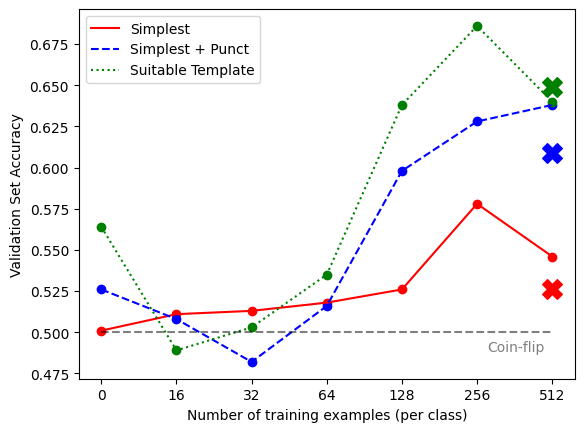

In [ ]:
## Ch 4 tutorial fig 1
x = (0, 16, 32, 64, 128, 256, 512)
y1 = [0.501, 0.511, 0.513, 0.518, 0.526, 0.578, 0.546] # test set = 0.526
y2 = [0.526, 0.508, 0.482, 0.516, 0.598, 0.628, 0.638] # test set = 0.609
y3 = [0.564, 0.489, 0.503, 0.535, 0.638, 0.686, 0.640] # test set = 0.649

fig1 = plt.figure()
ax11 = fig1.add_subplot(111)

ax11.plot(range(len(x)), y1, color='r', ls='-', label='Simplest')
ax11.scatter(range(len(x)), y1, color='r')
ax11.plot(range(len(x)), y2, color='b', ls='--', label='Simplest + Punct')
ax11.scatter(range(len(x)), y2, color='b')
ax11.plot(range(len(x)), y3, color='g', ls=':', label='Suitable Template')
ax11.scatter(range(len(x)), y3, color='g')
ax11.plot([0,len(x)-1],[0.5,0.5],'k--',alpha=0.5)
ax11.text(5.9,0.495,'Coin-flip',ha='right',va='top',color='k',alpha=0.5)

ax11.scatter(6,0.526,color='r',marker='X',s=200)
ax11.scatter(6,0.609,color='b',marker='X',s=200)
ax11.scatter(6,0.649,color='g',marker='X',s=200)

ax11.set_xticks(range(len(x)))
ax11.set_xticklabels(x)
ax11.set_xlabel('Number of training examples (per class)')
ax11.set_ylabel('Validation Set Accuracy')
ax11.legend()

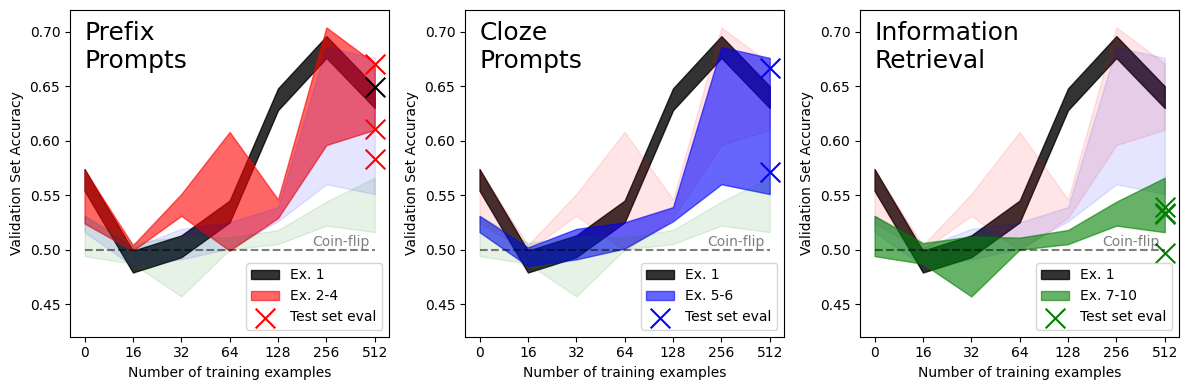

In [ ]:
# Ch4 tutorial fig2

ts = (0, 16, 32, 64, 128, 256, 512)
e1 = [0.564, 0.489, 0.503, 0.535, 0.638, 0.686, 0.64] # 0.649
e2 = [0.541, 0.504, 0.531, 0.544, 0.546, 0.596, 0.611] # 0.611
e3 = [0.573, 0.5, 0.551, 0.608, 0.531, 0.704, 0.671] # 0.67
e4 = [0.524, 0.499, 0.531, 0.499, 0.529, 0.616, 0.61] # 0.583
e5 = [0.531, 0.502, 0.519, 0.501, 0.526, 0.56, 0.676] # 0.667
e6 = [0.516, 0.485, 0.491, 0.525, 0.539, 0.686, 0.551] # 0.571
e7 = [0.495, 0.492, 0.457, 0.51, 0.508, 0.522, 0.557] # 0.539
e8 = [0.498, 0.487, 0.504, 0.5, 0.51, 0.54, 0.566] # 0.533
e9 = [0.531, 0.506, 0.512, 0.511, 0.518, 0.544, 0.516] # 0.497
e10 = [0.494, 0.496, 0.507, 0.507, 0.505, 0.537, 0.564] # 0.534

fig2 = plt.figure(figsize=(12,4))
ax21 = fig2.add_subplot(131)
ax22 = fig2.add_subplot(132)
ax23 = fig2.add_subplot(133)

bshade_min1 = [min(e2[i],e3[i],e4[i]) for i in range(len(ts))]
bshade_max1 = [max(e2[i],e3[i],e4[i]) for i in range(len(ts))]
bshade_min2 = [min(e5[i],e6[i]) for i in range(len(ts))]
bshade_max2 = [max(e5[i],e6[i]) for i in range(len(ts))]
bshade_min3 = [min(e7[i],e8[i],e9[i],e10[i]) for i in range(len(ts))]
bshade_max3 = [max(e7[i],e8[i],e9[i],e10[i]) for i in range(len(ts))]

ax21.fill_between(range(len(ts)),[i-0.01 for i in e1],[i+0.01 for i in e1],color='k',alpha=0.8, label='Ex. 1')
ax21.fill_between(range(len(ts)),bshade_min1,bshade_max1, color='r', alpha=0.6, label='Ex. 2-4')
ax21.fill_between(range(len(ts)),bshade_min2,bshade_max2, color='b', alpha=0.1)
ax21.fill_between(range(len(ts)),bshade_min3,bshade_max3, color='g', alpha=0.1)

ax22.fill_between(range(len(ts)),[i-0.01 for i in e1],[i+0.01 for i in e1],color='k',alpha=0.8, label='Ex. 1')
ax22.fill_between(range(len(ts)),bshade_min1,bshade_max1, color='r', alpha=0.1)
ax22.fill_between(range(len(ts)),bshade_min2,bshade_max2, color='b', alpha=0.6, label='Ex. 5-6')
ax22.fill_between(range(len(ts)),bshade_min3,bshade_max3, color='g', alpha=0.1)

ax23.fill_between(range(len(ts)),[i-0.01 for i in e1],[i+0.01 for i in e1],color='k',alpha=0.8, label='Ex. 1')
ax23.fill_between(range(len(ts)),bshade_min1,bshade_max1, color='r', alpha=0.1)
ax23.fill_between(range(len(ts)),bshade_min2,bshade_max2, color='b', alpha=0.1)
ax23.fill_between(range(len(ts)),bshade_min3,bshade_max3, color='g', alpha=0.6, label='Ex. 7-10')

ax21.scatter(6,0.649,color='k',marker='x',s=200)
ax21.scatter([6,6,6],[0.611, 0.67, 0.583],color='r',marker='x',s=200,label='Test set eval')
ax22.scatter([6,6],[0.667, 0.571],color='b',marker='x',s=200,label='Test set eval')
ax23.scatter([6,6,6,6],[0.539, 0.533, 0.497, 0.534],color='g',marker='x',s=200,label='Test set eval')

ax21.plot([0,len(ts)-1],[0.5,0.5],'k--',alpha=0.5)
ax21.text(5.9,0.501,'Coin-flip',ha='right',va='bottom',color='k',alpha=0.5)
ax22.plot([0,len(ts)-1],[0.5,0.5],'k--',alpha=0.5)
ax22.text(5.9,0.501,'Coin-flip',ha='right',va='bottom',color='k',alpha=0.5)
ax23.plot([0,len(ts)-1],[0.5,0.5],'k--',alpha=0.5)
ax23.text(5.9,0.501,'Coin-flip',ha='right',va='bottom',color='k',alpha=0.5)

ax21.set_xticks(range(len(ts)))
ax21.set_xticklabels(ts)
ax21.set_xlabel('Number of training examples')
ax21.set_ylabel('Validation Set Accuracy')
ax21.set_ylim(0.42, 0.72)
ax21.text(0., 0.71,'Prefix\nPrompts',ha='left',va='top',fontsize=18)
ax21.legend(loc=4)

ax22.set_xticks(range(len(ts)))
ax22.set_xticklabels(ts)
ax22.set_xlabel('Number of training examples')
ax22.set_ylabel('Validation Set Accuracy')
ax22.set_ylim(0.42, 0.72)
ax22.text(0., 0.71,'Cloze\nPrompts',ha='left',va='top',fontsize=18)
ax22.legend(loc=4)

ax23.set_xticks(range(len(ts)))
ax23.set_xticklabels(ts)
ax23.set_xlabel('Number of training examples')
ax23.set_ylabel('Validation Set Accuracy')
ax23.set_ylim(0.42, 0.72)
ax23.text(0., 0.71,'Information\nRetrieval',ha='left',va='top',fontsize=18)
ax23.legend(loc=4)

fig2.tight_layout()

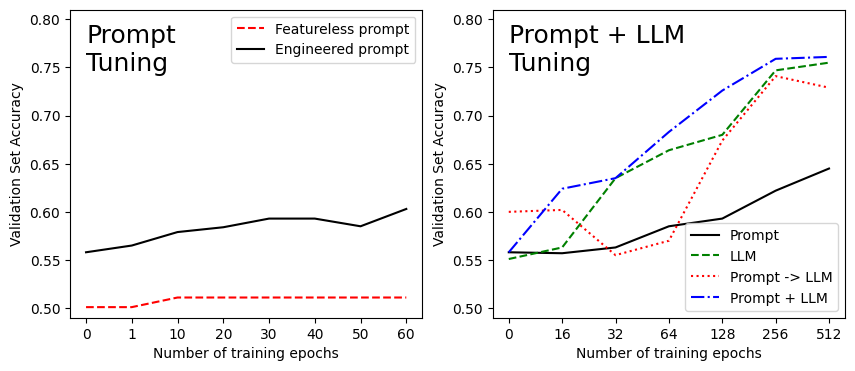

In [ ]:
steps_1 = (0, 1, 10, 20, 30, 40, 50, 60)
c1 = [0.501, 0.501, 0.511, 0.511, 0.511, 0.511, 0.511, 0.511] # basic
c2 = [0.558, 0.565, 0.579, 0.584, 0.593, 0.593, 0.585, 0.603] # optimal

steps_2 = (0, 16, 32, 64, 128, 256, 512)
c3 = [0.558, 0.557, 0.563, 0.585, 0.593, 0.622, 0.645] # Prompt
c4 = [0.551, 0.563, 0.635, 0.664, 0.680, 0.747, 0.755] # LLM
c5 = [0.600, 0.602, 0.555, 0.570, 0.674, 0.741, 0.729] # Prompt > LLM
c6 = [0.558, 0.624, 0.635, 0.683, 0.726, 0.759, 0.761]# Prompt + LLM

fig3 = plt.figure(figsize=(10,4))
ax31 = fig3.add_subplot(121)
ax32 = fig3.add_subplot(122)

ax31.plot(range(len(steps_1)), c1, label = 'Featureless prompt', color='r', ls='--')
ax31.plot(range(len(steps_1)), c2, label = 'Engineered prompt',color='k',ls='-')
ax31.set_xticks(range(len(steps_1)))
ax31.set_xticklabels(steps_1)
ax31.set_xlabel('Number of training epochs')
ax31.set_ylabel('Validation Set Accuracy')
ax31.text(0,0.795,'Prompt\nTuning',ha='left',va='top',fontsize=18)
ax31.set_ylim(0.49, 0.81)
ax31.legend()

ax32.plot(range(len(steps_2)), c3, label = 'Prompt', color='k', ls='-')
ax32.plot(range(len(steps_2)), c4, label = 'LLM', color='g', ls='--')
ax32.plot(range(len(steps_2)), c5, label = 'Prompt -> LLM', color='r',ls=':')
ax32.plot(range(len(steps_2)), c6, label = 'Prompt + LLM', color='b', ls='-.')
ax32.set_xticks(range(len(steps_2)))
ax32.set_xticklabels(steps_2)
ax32.set_xlabel('Number of training epochs')
ax32.set_ylabel('Validation Set Accuracy')
ax32.text(0,0.795,'Prompt + LLM\nTuning',ha='left',va='top',fontsize=18)
ax32.set_ylim(0.49, 0.81)
ax32.legend(loc=4)